In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn import feature_selection, linear_model, grid_search, cross_validation, metrics, ensemble, learning_curve 
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pickle
import xgboost as xgb
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Отбираем все ПОСЛЕДНИЕ залоговые билеты со статусом Новый залог
sql_query = "SELECT [Code] \
      ,[PartnerID] \
      ,IIf([Sex]='M',1,IIf([Sex]='F',0,NULL)) Sex \
      ,[Age] \
      ,[CreditCondition] \
      ,DATEDIFF(MONTH,[LombardFirstDealDate],IssueDate) LifeTimeMonth \
      ,[City] \
      ,[SumAmountzb] \
      ,[AVGAmountzb] \
      ,[ZB] \
      ,[Good] \
      ,[PercentGood] \
	  ,IIF(PromotionID = 0,0,1) PromotionID \
      ,QntNew/ZB PercentNew \
      ,[QntPerez]/ZB PercentPerez  \
      ,[QntOSN]/ZB PercentOSN \
      ,[QntBuyUp]/ZB PercentBuyUp \
      ,[AVGDneyZaloga] \
      ,[AVGDneySProshZB] \
      ,[AVGWeightGross] \
      ,[AVGCostPerGram] \
      ,[AVGCost] \
      ,[AVGPercentPerDay] \
      ,[MINPercentPerDay] \
      ,[MAXPercentPerDay] \
      ,[OverPayAmount] \
      ,[PercentAmount]  \
      ,[isGoodZB] \
  FROM [Gold585].[dbo].[CommonTable] a  \
  where IssueDate = (Select MAX(IssueDate) From CommonTable b where a.PartnerID = b.PartnerID) \
  and IssueDate > convert(datetime,'2017-11-01') and IssueDate < convert(datetime,'2018-06-01') and Category in ('Новая cсуда')"
data = pd.read_sql(sql_query,conn)

In [3]:
data.shape

(94744, 28)

In [4]:
data.head()

,Code,PartnerID,Sex,Age,CreditCondition,LifeTimeMonth,City,SumAmountzb,AVGAmountzb,ZB,...,AVGDneySProshZB,AVGWeightGross,AVGCostPerGram,AVGCost,AVGPercentPerDay,MINPercentPerDay,MAXPercentPerDay,OverPayAmount,PercentAmount,isGoodZB
0,620001197728,265042,0.0,30,1,53,2227A0224C18DF73B5A6CCAD33BD9119EB219F726FE844...,22696.00000,2063.272705,11,...,161,2.356300,834.337585,2072.254395,0.3218,0.30,0.35,0.000000,0.0,0
1,620001245028,171485,0.0,44,2,52,FE7C56DEBDD2D084C9F197DD9D4F9C43E0727F4D8B5C3B...,37744.00000,6290.666504,6,...,318,6.443300,1268.001587,6384.433105,0.4250,0.30,0.50,0.000000,0.0,0
2,630000681809,16660,0.0,36,1,54,C78C4BD44EE00B847C254FFA051EFA23C557829DF738FA...,894176.00000,6825.770996,131,...,14,7.834600,930.719910,7227.619141,0.2661,0.20,0.35,0.000000,0.0,0
3,630000426837,13166,1.0,43,5,51,D4BD0FDE6A73633AB4BB60111B430B65FDC14794AEDABF...,325084.03125,14776.546875,22,...,73,18.745399,985.508118,17993.849609,0.3609,0.30,0.40,3539.159912,0.0,0
4,620001275747,173033,1.0,39,2,57,2227A0224C18DF73B5A6CCAD33BD9119EB219F726FE844...,154650.00000,15465.000000,10,...,171,12.225000,1350.806519,15820.320312,0.3440,0.32,0.35,0.000000,0.0,1


In [5]:
df = data.fillna(0)
target=df.drop(['Code','PartnerID','City','isGoodZB'], axis=1)
target = pd.get_dummies(target, columns = ['Sex','CreditCondition'])
X = StandardScaler().fit_transform(target)

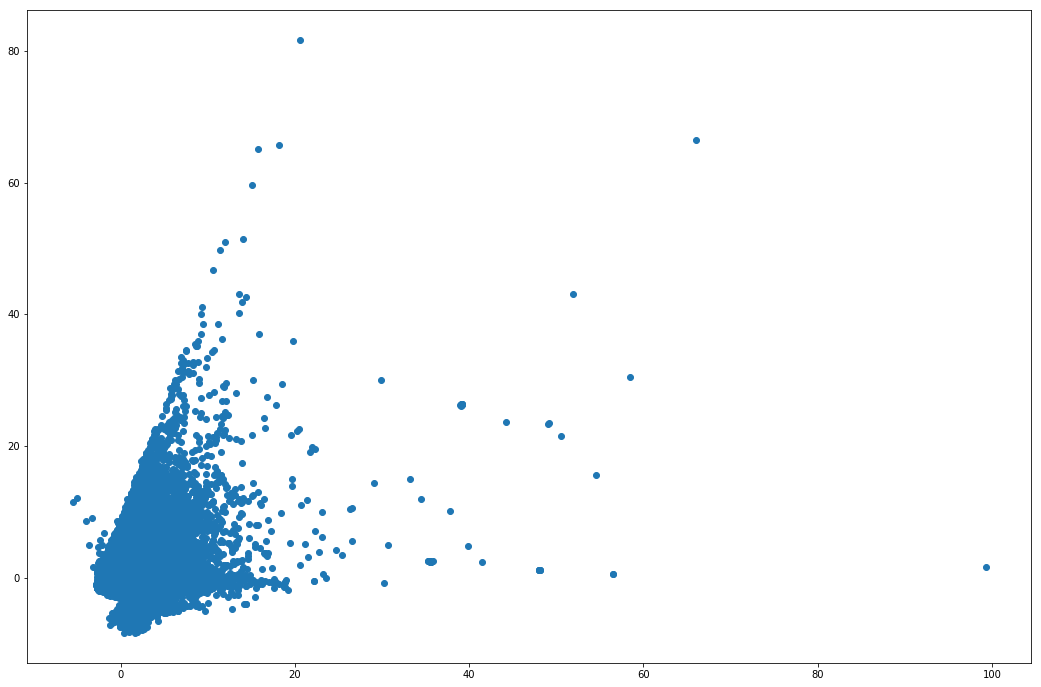

In [6]:
from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

In [7]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

def silhouette_samples_memory_saving(X, labels, metric='euclidean', **kwds):
    X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    check_number_of_labels(len(le.classes_), X.shape[0])

    unique_labels = le.classes_
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))

    # For sample i, store the mean distance of the cluster to which
    # it belongs in intra_clust_dists[i]
    intra_clust_dists = np.zeros(X.shape[0], dtype=X.dtype)

    # For sample i, store the mean distance of the second closest
    # cluster in inter_clust_dists[i]
    inter_clust_dists = np.inf + intra_clust_dists

    for curr_label in range(len(unique_labels)):

        # Find inter_clust_dist for all samples belonging to the same
        # label.
        mask = labels == curr_label

        # Leave out current sample.
        n_samples_curr_lab = n_samples_per_label[curr_label] - 1
        if n_samples_curr_lab != 0:
            intra_distances = pairwise_distances(X[mask, :], metric=metric, **kwds)
            intra_clust_dists[mask] = np.sum(intra_distances, axis=1) / n_samples_curr_lab

        # Now iterate over all other labels, finding the mean
        # cluster distance that is closest to every sample.
        for other_label in range(len(unique_labels)):
            if other_label != curr_label:
                other_mask = labels == other_label
                inter_distances = pairwise_distances(X[mask, :], X[other_mask, :], metric=metric, **kwds)
                other_distances = np.mean(inter_distances, axis=1)
                inter_clust_dists[mask] = np.minimum(inter_clust_dists[mask], other_distances)

    sil_samples = inter_clust_dists - intra_clust_dists
    sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    # score 0 for clusters of size 1, according to the paper
    sil_samples[n_samples_per_label.take(labels) == 1] = 0

    return sil_samples

In [9]:
X1 = pd.DataFrame(X).sample(10000)

In [12]:
X1.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
144961,2.321198,-0.645012,-0.056365,0.175668,-0.191987,-0.308233,-1.017303,-0.456445,0.527762,0.0,...,-0.804575,0.888694,-0.433551,-0.435687,-0.245325,-0.166039,-0.167759,-0.058831,-0.094158,-0.017349
31044,-1.276908,-0.645012,-0.092946,-0.298117,-0.265726,-0.308233,-1.017303,-0.456445,0.527762,0.0,...,-0.804575,0.888694,-0.433551,-0.435687,-0.245325,-0.166039,-0.167759,-0.058831,-0.094158,-0.017349
290017,-0.157497,0.162338,-0.095073,-0.558461,-0.118248,-0.209615,-0.271060,-0.456445,0.527762,0.0,...,1.242892,-1.125246,-0.433551,2.295228,-0.245325,-0.166039,-0.167759,-0.058831,-0.094158,-0.017349
207528,-0.237455,-0.174058,-0.047877,-0.325047,0.102969,0.086239,0.475184,-0.456445,0.527762,0.0,...,1.242892,-1.125246,2.306536,-0.435687,-0.245325,-0.166039,-0.167759,-0.058831,-0.094158,-0.017349
303745,-0.957077,-0.645012,-0.095193,-0.378003,-0.265726,-0.308233,-1.017303,-0.456445,0.527762,0.0,...,1.242892,0.888694,-0.433551,-0.435687,-0.245325,-0.166039,-0.167759,-0.058831,-0.094158,-0.017349


In [ ]:

mas = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    a= silhouette_samples_memory_saving(X1, kmeans.labels_)
    mas.append(a)
    print(a)

plt.plot(range(2, 11), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

[ 0.35143736  0.42089621 -0.11984885 ...  0.42762914  0.4305024
  0.27405563]
